# Bayesian inference: MCMC

## Table of Content:

- I-II-III Basic concepts of Bayesian inference: See [Bayes_basics.ipynb](Bayes_basics.ipynb)
- IV Simple Bayesian Modeling: See [Bayes_simple_modeling.ipynb](Bayes_simple_modeling.ipynb)
- V Bayesian modeling with [Monte Carlo Markov Chains (MCMC)](#V.-Bayesian-Modeling-with-MCMC)
    * V.1 [The Curse of dimensionality](#V.1-The-Curse-of-dimensionality)
    * V.2 [Circumventing the curse with sampling](#V.2-Circumventing-the-Curse-with-Sampling)
- X [References](#XX-References:)

## V. Bayesian Modeling with MCMC

In the previous section we explored a Bayesian solution to a straight line fit.
The result made use of the evaluation of a posterior across a grid of parameters: a strategy that *will not* scale to higher-dimensional models.

## V.1 The Curse of dimensionality

The reason it will not scale is one of the effects of the ubiquitous "Curse of Dimensionality". To understand this, consider how many evaluations we need for an $N$-dimensional grid with 100 samples per dimension

In one dimension, we have $100$ points.

In two dimensions we have $100^2 = 10,000$ evaluations.

In three dimensions, we have $100^3 = 1,000,000$ evaluations.

In $N$ dimensions, we have $100^N$ evaluations, and as $N$ grows this quickly becomes untenable! For example, if we have only six model parameters, this "dense grid" approach will require evaluating the posterior at one trillion grid points, the results of which would require several terabytes of memory just to store!

Evidently the dense grid strategy will not work for any but the simplest Bayesian models.

## V.2 Circumventing the Curse with Sampling

An idea that revolutionized Bayesian modeling (and made possible the wide variety of Bayesian approaches used in practice today) is *Markov Chain Monte Carlo* (MCMC), an approach that allows one to efficiently draw (pseudo)random samples from a posterior distribution even in relatively high dimensions.

### V.2.1 The Metropolis-Hastings Sampler

Perhaps the simplest of MCMC samplers is the *Metropolis-Hastings Sampler*.
This provides a procedure which, given a pseudo-random number generator, selects a chain of points which (in the long-term limit) will be a representative sample from the posterior. The procedure is surprisingly simple:

1. Define a posterior $p(\theta~|~D, I)$
2. Define a *proposal density* $p(\theta_{i + 1}~|~\theta_i)$, which must be a symmetric function, but otherwise is unconstrained (a Gaussian is the usual choice). This defines the way you fix the next step. 
3. Choose a starting point $\theta_0$
4. Repeat the following:

   1. Given $\theta_i$, draw a new $\theta_{i + 1}$
   
   2. Compute the *acceptance ratio*
      $$
      a = \frac{p(\theta_{i + 1}~|~D,I)}{p(\theta_i~|~D,I)}
      $$
   
   3. If $a \ge 1$, the proposal is more likely: accept the draw and add $\theta_{i + 1}$ to the chain.
   
   4. If $a < 1$, then accept the point with probability $a$: this can be done by drawing a uniform random number $r$ and checking if $a < r$. If the point is accepted, add $\theta_{i + 1}$ to the chain. If not, then add $\theta_i$ to the chain *again*.

There are a few caveats to be aware of when using MCMC

#### 1. The procedure is provably correct... but only in the long-term limit!

Sometimes the long-term limit is **very** long. What we're looking for is "stabilization" of the MCMC chain, meaning that it has reached a statistical equilibrium. There is a vast literature on how to measure stabilization of an MCMC chain. Here we'll use the sloppy but intuitive LAI approach (i.e. Look At It).

#### 2. The size of the proposal distribution is *very* important

- If your proposal distribution is too small, it will take too long for your chain to move, and you have the danger of getting stuck in a local maximum for a long (but not infinite) time.

- If your proposal distribution is too large, you will not be able to efficiently explore the space around a particular peak

In general, choosing an appropriate scale for the proposal distribution is one of the most difficult parts of using the MCMC procedure above.
More sophisticated methods (see later) have built-in ways to estimate this along the way, but it's still something to be aware of!

#### 3. Fast Stabilization can be helped by good initialization

In practice, assuring that MCMC will stabilize quickly has a lot to do with choosing a suitable initialization. For this purpose, it can be useful to find the maximum a posteriori (MAP) value, and initialize the chain with this.

### V.2.2 Sampling with ``emcee``

There are several good Python approaches to Bayesian computation with MCMC. 
Here we'll focus on [``emcee``](http://dan.iel.fm/emcee/), a lightweight Python package developed by Dan Foreman-Mackey and collaborators.
One benefit of ``emcee`` is that it uses an *ensemble sampler* which automatically tunes the shape and size of the proposal distribution (you can read more details in the ``emcee`` documentation).

Let's apply MCMC to our simple line fitting problem. The following steps are required: 

#### V2.2.1 Expression of the posterior (likelihood and prior)

For that purpose, we need first to define a function that enables us to evaluate the posterior:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

<Container object of 3 artists>

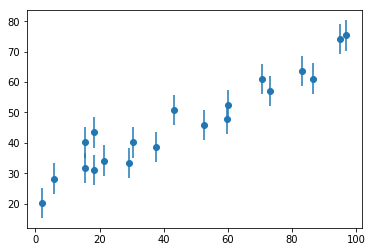

In [2]:
# Function that generates points following a linear trend. 
def make_data(intercept, slope, N=20, dy=5, rseed=42):
    '''
    Parameters:
    -----------
    intercept, slope: parameters of the linear model
    dy: width of normally distributed data points around the "true line"
    rseed: Seed of the random number generator (fixed for the sake of discussion)
    Output:
    -------
    x, y, sig_y 
    '''
    rand = np.random.RandomState(rseed)
    x = 100 * rand.rand(N)
    y = intercept + slope * x
    y += dy * rand.randn(N)
    return x, y, dy * np.ones_like(x)

theta_true = [25, 0.5]
x, y, dy = make_data(theta_true[0], theta_true[1])  # could also be make_data(*theta_true)
plt.errorbar(x, y, dy, fmt='o')

In [3]:
# Likelihood and Prior (cf Bayes_simple_modeling.ipynb)
def ln_likelihood(theta, x, y, dy):
    y_model = theta[0] + theta[1] * x
    return -0.5 * np.sum(np.log(2 * np.pi * dy ** 2) + (y - y_model) ** 2 / dy ** 2)

def ln_flat_prior(theta):
    '''
    theta = shape(2) array containing the [intercept, slope] = [theta_0, theta_1]
    '''
    if np.all(np.abs(theta[1]) < 1000):
        return 0 # log(1)
    else:
        return -np.inf  # log(0)

In [4]:
def ln_posterior(theta, x, y, dy):
    return ln_flat_prior(theta) + ln_likelihood(theta, x, y, dy)

#### V.2.2.2 Using emcee to sample the posterior

In [ ]:
# !pip install emcee   # If emcee is not installed on your machine 

In [11]:
import emcee
import importlib
importlib.reload(emcee)

ndim = 2  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
#sampler.reset()  # Uncomment if you start over, ignoring what you did before
# initialize walkers ; You can make a more refined start ! Closer to expected value parameters ... , e.g. based on MLE ...
starting_guesses = np.random.randn(nwalkers, ndim)

# Set up the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior, args=[x, y, dy])  # This sets up the posterior

# starting_guesses = The initial position vector.  
# Can also be None to resume from where :func:``run_mcmc`` left off the last time it executed.
# param1 = # of steps to run (here: 200)
pos, prob, state = sampler.run_mcmc(starting_guesses, 200)  

In [6]:
sampler.chain.shape

(50, 200, 2)

In [7]:
starting_guesses.shape

(50, 2)

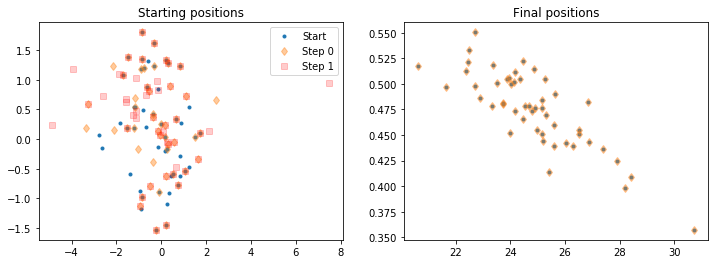

In [12]:
f, ax = plt.subplots(ncols=2, figsize=(12,4))
ax[0].plot(starting_guesses[:,0], starting_guesses[:,1], ls='', marker='.', label='Start')
ax[0].set_title('Starting positions')
ax[0].plot(sampler.chain[:, 0, 0], sampler.chain[:, 0, 1], ls='', marker='d', alpha=0.4, label='Step 0')
ax[0].plot(sampler.chain[:, 1, 0], sampler.chain[:, 1, 1], ls='', color='red', marker='s', alpha=0.2, label='Step 1')
ax[0].legend()
ax[1].plot(pos[:,0], pos[:,1], ls='', marker='.')
ax[1].set_title('Final positions')
ax[1].plot(sampler.chain[:, 199, 0], sampler.chain[:, 199, 1], ls='', marker='d', alpha=0.4)

#### V.2.2.3 Plotting the chains

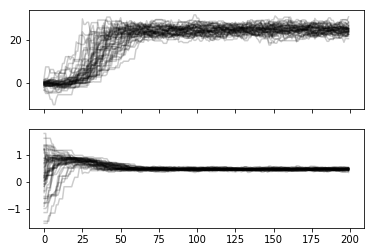

In [13]:
fig, ax = plt.subplots(2, sharex=True)
for i in range(2):
    ax[i].plot(sampler.chain[:, :, i].T, '-k', alpha=0.2)

#### V.2.2.4 Restarting after burn-in

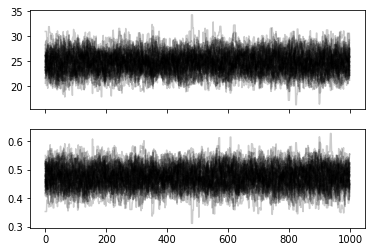

In [14]:
sampler.reset()
pos, prob, state = sampler.run_mcmc(pos, 1000)

fig, ax = plt.subplots(2, sharex=True)
for i in range(2):
    ax[i].plot(sampler.chain[:, :, i].T, '-k', alpha=0.2)

Using the [corner.py](https://pypi.python.org/pypi/corner) package, we can take a look at this multi-dimensional posterior, along with the input values for the parameters:

In [15]:
# !pip install corner

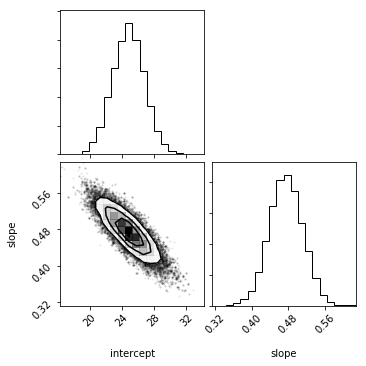

In [16]:
import corner
qq = corner.corner(sampler.flatchain, labels=['intercept', 'slope'])

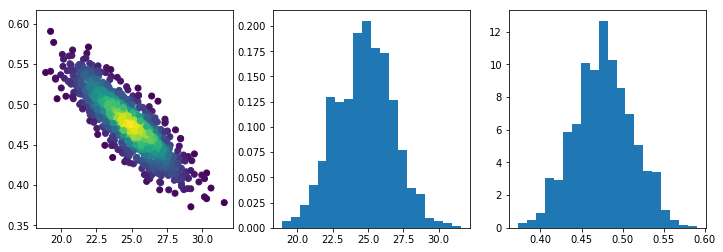

In [17]:
# If corner is not installed, you can simply do the following
from scipy.stats import gaussian_kde
#t0, t1 = sampler.flatchain[:,0], sampler.flatchain[:,1]   # full chain ... a bit expensive for calculating the density of points
rd = np.random.choice(len(sampler.flatchain[:,0]), 1000)  # I pick 1000 random pos in my chain
t0 = [sampler.flatchain[i,0] for i in rd]
t1 = [sampler.flatchain[i,1] for i in rd]
# Calculate the point density
t01 = np.vstack([t0,t1])
density = gaussian_kde(t01)(t01)

f, ax = plt.subplots(ncols=3, figsize=(12,4))
ax[0].scatter(t0, t1, c=density)
h1 = ax[1].hist(t0, bins=20, normed=True)
h2 = ax[2].hist(t1, bins=20, normed=True)

#### V.2.2.5 Visualizing the posterior

A way to visualize the posterior is to plot the model over the data.
Each point in the two-dimensional space ($\theta_0$,$\theta_1$) explored by the sampler, corresponds to a possible model for our data. If we select ~100 of these at random and plot them over our data, it will give us a good idea of the spread in the model results:

In [ ]:
chain = sampler.flatchain
chain.shape

In [ ]:
xfit = np.linspace(0, 100)
thetas = [chain[i] for i in np.random.choice(chain.shape[0], 100)]  # you randomly pick 100 pairs of parameters from the chain

for i in range(100):
    theta = thetas[i]
    plt.plot(xfit, theta[0] + theta[1] * xfit, color='black', alpha=0.05)

plt.errorbar(x, y, dy, fmt='o');



### V.2.3. Fitting a straight line with intrinsic scatter

Above we have done a simple model, where the data is drawn from a straight line.

Often, however, we will be modeling relationships where there is some intrinsic scatter in the model itself: that is, even if the data were *perfectly* measured, they would not fall along a perfect straight line, but would have some (unknown) scatter about that line.

Here we'll make a slightly more complicated model in which we will fit for the slope, intercept, and intrinsic scatter (i.e. intrinsic scatter is a parameter of our model) all at once.

<Container object of 3 artists>

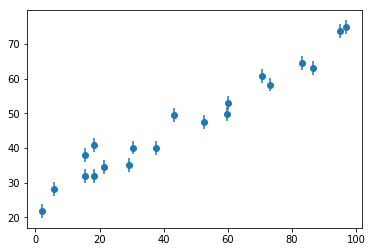

In [3]:
def make_data_scatter(intercept, slope, scatter, N=20, dy=2, rseed=42):
    rand = np.random.RandomState(rseed)
    x = 100 * rand.rand(N)
    y = intercept + slope * x
    y += np.sqrt(dy ** 2 + scatter ** 2) * rand.randn(N)
    return x, y, dy * np.ones_like(x)

theta = (25, 0.5, 3.0)  # (intercept, slope, intrinsic scatter)
x, y, dy = make_data_scatter(*theta)
plt.errorbar(x, y, dy, fmt='o')

We will now go through the different steps to solve this problem in a Bayesian way, and use MCMC to evaluate the posterior on the parameters. 

#### V.2.3.1 Defining the likelihood and prior

You are now getting familiar with the first step of the procedure which consists in deriving an expression for the likelihood. The likelihood for this model looks very similar to what we used above, except that the intrinsic scatter is added *in quadrature* to the measurement error.


$$
P(D\mid\boldsymbol{\theta}) =  \prod_{i=1}^{N} \frac{1}{\sqrt{2\,\pi (\sigma_i^2 + \sigma^2)}} \, \exp\left[\left (\frac{ -(y_i - (\theta_0+\theta_1\,x_i))^2}{2\,(\sigma_i^2+\sigma^2)} \right)\right]
$$

For the prior, you can use either a flat or symmetric prior on the slope and intercept, but on the intrinsic scatter $\sigma$ it is best to use a scale-invariant Jeffreys Prior:

$$
P(\sigma)\propto\sigma^{-1}
$$

As discussed before, this has the nice feature that the resulting posterior will not depend on the units of measurement.

### Exercise

In [16]:
# Define functions to compute the log-prior, log-likelihood, and log-posterior

# theta = [intercept, slope, scatter]

def ln_prior(theta):
    '''
    Function returning the log prior
    
    theta = shape(3) 
        array containing the [intercept, slope, scatter] = [theta_0, theta_1, theta_2]
    '''
    if ((np.abs(theta[0]) < 1000) & ( theta[2] > 0)) :
        return -1.5 * np.log(1 + theta[1] ** 2) + np.log(1./theta[2])
    else:
        return -np.inf  # log(0)
    
def ln_flat_prior(theta):
    '''
    Function returning the log prior: flat prior on theta_0 and theta_1
    
    '''
    if np.all(np.abs(theta[1]) < 1000) & (theta[2] > 0):
        
        return 0 + np.log(1./theta[2]) 
    else:
        return -np.inf  # log(0)    
    
def ln_likelihood(theta, x, y, dy):
    '''
    ln(likelihood) 
    '''
    y_model = theta[0] + theta[1] * x
    S = dy ** 2 + theta[2] ** 2
    return -0.5 * np.sum(np.log( 2 * np.pi * S ) 
                                + (y - y_model) ** 2 / S ) 

def ln_posterior(theta, x, y, dy):
    return ln_likelihood(theta, x, y, dy) + ln_prior(theta)                               
                      

#### Sampling from the Posterior

In [26]:
# Using emcee, create and initialize a sampler and draw 200 samples from the posterior.
# Remember to think about what starting guesses should you use!

import emcee

ndim = 3  # number of parameters in the model
nwalkers = 100  # number of MCMC walkers

# initialize walkers
starting_guesses = np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior, args=[x, y, dy])

pos, prob, state = sampler.run_mcmc(starting_guesses, 1000)


/Users/Shared/anaconda2/envs/intel-python2/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/Shared/anaconda2/envs/intel-python2/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


#### Visualizing the Chains

In [27]:
sampler.chain.shape

(100, 1000, 3)

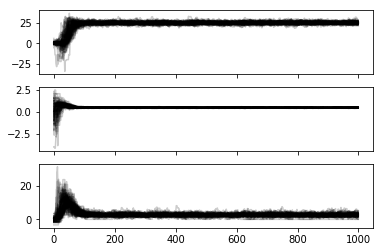

In [28]:
# Plot the three chains as above
# Are your chains stabilized? Reset them and get a clean sample
fig, ax = plt.subplots(3, sharex=True)
for i in range(3):
    ax[i].plot(sampler.chain[:, :, i].T, '-k', alpha=0.2)

#### Resetting and getting a clean sample

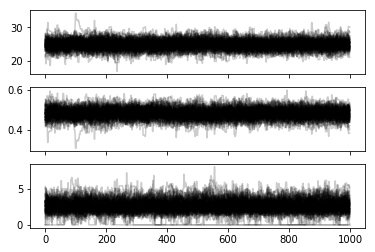

In [29]:
sampler.reset()
pos, prob, state = sampler.run_mcmc(pos, 1000)

fig, ax = plt.subplots(3, sharex=True)
for i in range(3):
    ax[i].plot(sampler.chain[:, :, i].T, '-k', alpha=0.2)


#### Visualizing the results

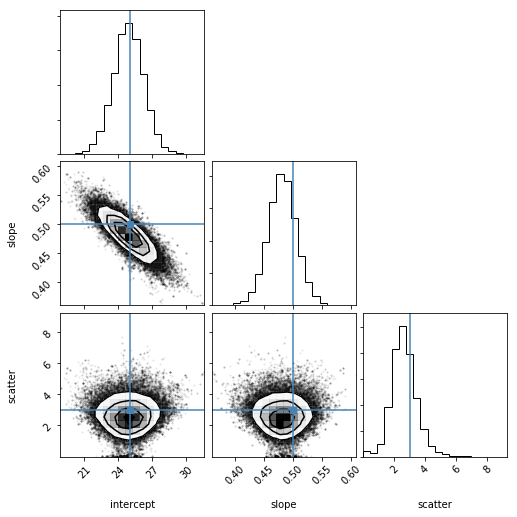

In [20]:
# Use e.g. corner.py to visualize the three-dimensional posterior
import corner
theta_truth = (25, 0.5, 3.0) 
qq = corner.corner(sampler.flatchain, truths=theta_truth, labels=['intercept', 'slope', 'scatter'])

In [31]:
# We see here that the sampler.chain saves the results in a 
# 3D array of shape(nwalkers, nchains, ndim)
sampler.chain.shape

(100, 1000, 3)

In [30]:
# Since the chain have converged we can flatten them all to get our samples of the posterior
chain = sampler.flatchain
chain.shape

(100000, 3)

In [37]:
chain[100]

array([25.94048423,  0.45208402,  2.06032259])

(100, 3)


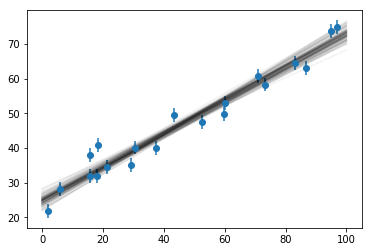

In [38]:
# Next plot ~100 of the samples as models over the data to get an idea of the fit
chain = sampler.flatchain

plt.errorbar(x, y, dy, fmt='o') # Plot the data 

thetas = [chain[i] for i in np.random.choice(chain.shape[0], 100)]  # Take 100 values from the final chain

# Alternative way to save the thetas for the 100 random values 
#thetas= np.zeros(shape=(100, 3))
#for j, i in enumerate(np.random.choice(chain.shape[0], 100)):
    # thetas[j, :] = chain[i]

print(thetas.shape)

xfit = np.linspace(0, 100)
for i in range(100):
    theta = thetas[i]
    plt.plot(xfit, theta[0] + theta[1] * xfit, color='black', alpha=0.05)

## XX References:

**Chapter 5** (5.1, 5.2, 5.3, 5.8) of the book <a class="anchor" id="book"></a> *Statistics, data mining and Machine learning in astronomy* by Z. Ivezic et al. in Princeton Series in Modern Astronomy. 

- This notebook includes a large fraction of the material that J. Vander Plas gave during the "Bayesian Methods in Astronomy workshop", presented at the 227th meeting of the American Astronomical Society. The full repository with that material can be found on GitHub: http://github.com/jakevdp/AAS227Workshop

- More insights on the differences between frequentist and Bayesian approaches: see [J. VanderPlass blog posts](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/) 

- Jayes: [*Probability Theory: The Logic of Science*](http://bayes.wustl.edu/etj/prob/book.pdf).

- For some approachable reading on frequentist vs. Bayesian uncertainties, I'd suggest [The Fallacy of Placing Confidence in Confidence Intervals](https://learnbayes.org/papers/confidenceIntervalsFallacy/), as well as Jake VanderPlast blog post on the topic, [Confidence, Credibility, and why Frequentism and Science do not Mix](http://jakevdp.github.io/blog/2014/06/12/frequentism-and-bayesianism-3-confidence-credibility/).

- Foreman-Mackey et al. 2012 [*EMCEE, the MCMC hammer*](https://arxiv.org/abs/1202.3665) ; see also http://dan.iel.fm/emcee/current/

- About the variety of approaches to MCMC: Allison and Dunkley 2013: [Comparison of sampling techniques for Bayesian parameter estimation](https://arxiv.org/abs/1308.2675). See also [How to Be a Bayesian in Python](http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/). 

- Andreon 2011 [Understanding better (some) astronomical data using Bayesian methods](https://arxiv.org/abs/1112.3652)